# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import random
from time import sleep

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, SpatialDropout1D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.layers import Flatten, InputSpec, Layer, Concatenate, AveragePooling2D, MaxPooling2D, Reshape, Permute
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D, LayerNormalization
from tensorflow.keras.layers import TimeDistributed, Lambda, AveragePooling1D, Add, Conv1D, Multiply
from tensorflow.keras.constraints import max_norm, unit_norm 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import mode
from itertools import product

## Experiment Information
Record the experiment information in these fields to be saved with the experiment

In [ ]:
TRIAL_NUM = 5
EXPER_NUM = 6
DATA_PATH = './datasets/movement_dataset_v4'

experiemnt_desc = \
"""
# Optimization run for game interactive training session

## Description
- Using model found from: https://github.com/vinayakr99/Muse-MotorImageryClassification
- Running with cross validation
- Trying with only taking intent before action
- Trying on being on wheelchair pushed model with Ridvan's data
"""

LABEL_MAP = {0: "BRAKE",
             1: "ACCEL",
             2: "LEFT",
             3: "RIGHT",
             4: "PASSIVE",
             5: "DISCONNECTED",
             6: "AMBIGUOUS"}

In [3]:
# Make directories to save data

RESULTS_DIR = './results/trial%s/experiment%s' % (TRIAL_NUM, EXPER_NUM)

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    
description_file = os.path.join(RESULTS_DIR, 'experiment%s_readme.md' % EXPER_NUM)

# Save description
with open(description_file, 'w') as f:
    f.write(experiemnt_desc)
    f.close()

## Helper functions

In [4]:
def rolling_mode_smoothing(data, window):
    output = []
    for frame in pd.Series(data).rolling(window):
        output.append(mode(frame)[0])
        
    return np.array(output)

In [5]:
#SMOOTHING_WINDOW = 100 # Eliminates any bumps under 0.25s
def compile_speed_segments(files, window, wait, hold):
    X = []
    t = []
    for file in files:
        session = pd.read_csv(file, header=None).to_numpy()
        
        count = 0
        timestamps = session[:, 0]
        speeds = session[:, 1]
        data = session[:, 3:]
        
#         plt.plot(timestamps, speeds)
#         plt.title("Accel break label")
#         plt.show()
        # smooth out labels
#         speeds = rolling_mode_smoothing(speeds, SMOOTHING_WINDOW)
#         plt.plot(timestamps, speeds)
#         plt.show()
        
        discon_segment = []
        
        for i in range(len(session)-1):
            if timestamps[i+1] - timestamps[i] > 1000000000:
#                 print("OSC delay too long")
                pass
                
            # If the data was ambiguous, then skip
            if speeds[i] == 6:
                continue
                
            # If the data is disconnected, collect in disconnected segments'
            if speeds[i] == 5:
                discon_segment.append(data[i])
                
            # reaching max disconnected size save as segment
            if len(discon_segment) == window:
                X.append(discon_segment)
                t.append(np.eye(len(LABEL_MAP))[int(speeds[i])])
                discon_segment = []
            
            # Clear if reached end of disconnect
            if speeds[i] == 5 and speeds[i+1] != 5:
                discon_segment = []
            
            if speeds[i] != speeds[i+1]:
                # Observe rising edge as data
                if speeds[i+1] in (1, 0):
                    # If the speed stays constant for wait time
                    if (speeds[i+1:i+wait] == speeds[i+1]).all() and \
                            len(data[i-int(window)+1:i+1]) == window:
                        # Save speed segments at the rising edge of every active region
                        X.append(data[i-int(window)+1:i+1])
                        t.append(np.eye(len(LABEL_MAP))[int(speeds[i+1])])
                    # if the user is still holding the button ns after the rising edge, then it is passive data
                    if (speeds[i+1:i+1+int(hold)+window] == speeds[i+1]).all() and \
                            len(data[i+1+int(hold):i+1+int(hold)+window]) == window:
                        X.append(data[i+1+int(hold):i+1+int(hold)+window])
                        t.append(np.eye(len(LABEL_MAP))[4])

    return np.array(X).astype(np.float32).transpose(0, 2, 1), np.array(t).astype(np.float32)

In [6]:

def compile_direction_segments(files):
    X = []
    t = []

    for file in files:
        session = pd.read_csv(file, header=None).to_numpy()
        
        count = 0
        timestamps = session[:, 0]
        directions = session[:, 2]
        data = session[:, 3:]
        
        plt.plot(timestamps, directions)
        plt.title("Left right label")
        plt.show()
        #plt.plot(timestamps, rolling_mode_smoothing(directions, SMOOTHING_WINDOW))
        #plt.show()
        
        discon_segment = []
        straight_segment = []
        
        for i in range(len(session)-1):
            if timestamps[i+1] - timestamps[i] > 1000000000:
                print("OSC delay too long")
                
            # If the data was ambiguous, then skip
            if directions[i] == 6:
                continue
                
            # If the data is disconnected, collect in disconnected segments'
            if directions[i] == 5:
                discon_segment.append(data[i])
                
            # reaching max disconnected size save as segment
            if len(discon_segment) == SEGMENT_WINDOW_SIZE:
                X.append(discon_segment)
                t.append(np.eye(len(label_map))[int(directions[i])])
                discon_segment = []
            
            # Clear if reached end of disconnect
            if directions[i] == 5 and directions[i+1] != 5:
                discon_segment = []
                
            # If the direction is passive, collect as a segment
            if directions[i] == 4:
                straight_segment.append(data[i])
            
            if len(straight_segment) == SEGMENT_WINDOW_SIZE:
                X.append(straight_segment)
                t.append(np.eye(len(label_map))[int(directions[i])])
                straight_segment = []
                
            if directions[i] == 4 and directions[i+1] != 4:
                straight_segment = []
            
            if directions[i] != directions[i+1]:
                # Save turn segments at the rising edge of every active region
                if directions[i+1] in (2, 3):
                    if (directions[i+1:i+ACTIVE_HOLD_PERIOD] == directions[i+1]).all() and \
                            len(data[i-int(SEGMENT_WINDOW_SIZE/2)+1:i+int(SEGMENT_WINDOW_SIZE/2)+1]) == SEGMENT_WINDOW_SIZE:
                        X.append(data[i-int(SEGMENT_WINDOW_SIZE/2)+1:i+int(SEGMENT_WINDOW_SIZE/2)+1])
                        t.append(np.eye(len(label_map))[int(directions[i+1])])
                
                
    return np.array(X).astype(np.float32), np.array(t).astype(np.float32)

In [7]:
# Balance categories
def balance_categories(X, t):
    max_per_label = min(t.sum(axis=0)[np.nonzero(t.sum(axis=0))])
    counts = [max_per_label for i in range(len(t[0]))]
    new_X = []
    new_t = []

    for i in range(len(X)):
        if (np.array(new_t).sum(axis=0) + t[i] <= counts).all():
            new_X.append(X[i])
            new_t.append(t[i])
            
    return np.array(new_X), np.array(new_t)
              

In [8]:


def create_model(shape, n_ff, n_sf, drop_rate, output_size):
    
    num_frames, num_channels, frame_size = shape

    # Input layer
    input_layer = Input(shape=(num_channels, frame_size, 1))

    block1 = Conv2D(n_ff[0], (1, 16), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_1')(input_layer)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[0], activation = 'linear', 
                           depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_1')(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)

    #================================

    block2 = Conv2D(n_ff[1], (1, 32), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_2')(input_layer)
    block2 = BatchNormalization()(block2)
    block2 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[1], activation = 'linear', 
                           depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_2')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)

    #================================

    block3 = Conv2D(n_ff[2], (1, 64), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_3')(input_layer)
    block3 = BatchNormalization()(block3)
    block3 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[2], activation = 'linear', 
                           depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_3')(block3)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)

    #================================

    block4 = Conv2D(n_ff[3], (1, 128), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_4')(input_layer)
    block4 = BatchNormalization()(block4)
    block4 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[3], activation = 'linear', 
                           depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_4')(block4)
    block4 = BatchNormalization()(block4)
    block4 = Activation('elu')(block4)

    #================================

    block = Concatenate(axis = -1)([block1, block2, block3, block4]) 

    #================================

    block = AveragePooling2D((1, 4))(block)
    block_in = Dropout(drop_rate)(block)

    #================================

    paddings = tf.constant([[0,0], [0,0], [3,0], [0,0]])
    block = tf.pad(block_in, paddings, "CONSTANT")
    block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Dropout(drop_rate)(block)
    block = tf.pad(block, paddings, "CONSTANT")
    block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Dropout(drop_rate)(block)
    block_out = Add()([block_in, block])


    paddings = tf.constant([[0,0], [0,0], [6,0], [0,0]])
    block = tf.pad(block_out, paddings, "CONSTANT")
    block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Dropout(drop_rate)(block)
    block = tf.pad(block, paddings, "CONSTANT")
    block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Dropout(drop_rate)(block)
    block_out = Add()([block_out, block])


    paddings = tf.constant([[0,0], [0,0], [12,0], [0,0]])
    block = tf.pad(block_out, paddings, "CONSTANT")
    block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Dropout(drop_rate)(block)
    block = tf.pad(block, paddings, "CONSTANT")
    block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Dropout(drop_rate)(block)
    block_out = Add()([block_out, block]) 


    paddings = tf.constant([[0,0], [0,0], [24,0], [0,0]])
    block = tf.pad(block_out, paddings, "CONSTANT")
    block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Dropout(drop_rate)(block)
    block = tf.pad(block, paddings, "CONSTANT")
    block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Dropout(drop_rate)(block)
    block_out = Add()([block_out, block]) 

    #================================

    block = block_out

    #================================

    block = Conv2D(28, (1,1))(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = AveragePooling2D((1,4), data_format='Channels_last')(block) #'Channels_last' As CPU will be used for inference
    block = Dropout(drop_rate)(block) 
    embedded = Flatten()(block)

    dense = Dense(128, activation='relu')(embedded)
    dense = Dropout(drop_rate)(dense)
    dense = Dense(64, activation='relu')(dense)
    output = Dense(output_size, activation='softmax', kernel_constraint = max_norm(0.2))(embedded)

    model = Model(inputs=input_layer, outputs=output)
    
    return model

In [9]:
def compile_model(model, learning_rate, beta_1, beta_2):
    adam = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, clipvalue=0.01)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
def fit(model, X_train, t_train, X_val, t_val,
        epochs, batch_size,
        model_file, log_file):
    model_checkpoint_callback = ModelCheckpoint(
        filepath=model_file,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    results = model.fit(X_train, t_train, validation_data=(X_val, t_val), batch_size=batch_size, epochs=epochs, shuffle=True, callbacks=[model_checkpoint_callback])

    return results

In [11]:
def evaluate_results(attempt_num, iter_num,
                     results, X_train, t_train, X_val, t_val, X_test, t_test,
                     model_file, loss_graph, accuracy_graph, conf_matrix):
    model = tf.keras.models.load_model(model_file)
    test_results = model.evaluate(X_test, t_test, batch_size = 1)
    train_results = model.evaluate(X_train, t_train, batch_size = 1)
    val_results = model.evaluate(X_val, t_val, batch_size = 1)
    
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])
    plt.plot([test_results[0] for i in range(len(results.history['loss']))])
    plt.legend(('training loss', 'validation loss', 'test loss'))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Trial %s Attempt %s Interation %s Loss" % (TRIAL_NUM, attempt_num, iter_num))
    plt.grid()
    plt.savefig(loss_graph)
    plt.show()
    
    plt.plot(results.history['accuracy'])
    plt.plot(results.history['val_accuracy'])
    plt.plot([test_results[1] for i in range(len(results.history['accuracy']))])
    plt.legend(('training accuracy', 'validation accuracy', 'test accuracy'))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Trial %s Attempt %s Interation %s Accuracy" % (TRIAL_NUM, attempt_num, iter_num))
    plt.grid()
    plt.savefig(accuracy_graph)
    plt.show()
    
    labels = ['BRAKE', 'ACCEL', 'PASSIVE', 'DISCONNECTED']
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    y_test = np.argmax(t_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    try:
        plot = disp.plot()
    except:
        pass

    plt.savefig(conf_matrix)
    plt.show()
    
    return train_results, val_results, test_results

# Steps

In [12]:
def attempt(attempt_num,
            xv_n_splits, max_iter,
            hold_time, wait_time, window_time,
            freq_filter_num, spatial_filter_num, drop_rate,
            learning_rate, beta_1, beta_2,
            epochs, batch_size
            ):

    # Make all directories and file names
    attempt_dir = os.path.join(RESULTS_DIR, 'attempt%s' % attempt_num)
    if not os.path.exists(attempt_dir):
        os.makedirs(attempt_dir)
    
    interm_dir = os.path.join(attempt_dir, 'processed_data/')
    if not os.path.exists(interm_dir):
        os.makedirs(interm_dir)
        
    model_dir = os.path.join(attempt_dir, 'models/')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    accuracy_dir = os.path.join(attempt_dir, 'accuracy/')
    if not os.path.exists(accuracy_dir):
        os.makedirs(accuracy_dir)
        
    loss_dir = os.path.join(attempt_dir, 'loss/')
    if not os.path.exists(loss_dir):
        os.makedirs(loss_dir)
        
    conf_dir = os.path.join(attempt_dir, 'confusion/')
    if not os.path.exists(conf_dir):
        os.makedirs(conf_dir)

    summary_file = os.path.join(attempt_dir, 'model_summary.txt')

    log_file = os.path.join(attempt_dir, 'training.log')
    
    stdout = sys.stdout
    f = open(log_file, 'w')
    sys.stdout = f
    
    # Get files
    files = shuffle(glob.glob(os.path.join(DATA_PATH, 'ridvan_1*.csv')))
    
    file_data = []
    
    # compile files
    for file in files:
        print('Converting file %s' % file)
        X_file = os.path.join(interm_dir, '%s_X.npy' % os.path.splitext(os.path.basename(file))[0])
        t_file = os.path.join(interm_dir, '%s_t.npy' % os.path.splitext(os.path.basename(file))[0])
        if os.path.exists(X_file) and os.path.exists(t_file):
            X = np.load(X_file)
            t = np.load(t_file)
        else:
            X, t = compile_speed_segments([file], hold=hold_time, wait=wait_time, window=window_time)
#             X, t = balance_categories(X, t)
            np.save(X_file, X)
            np.save(t_file, t)
        file_data.append((X, t))
        
    print('Total of %s datasets' % len(file_data))
    
    # Prepare test data
#     X_test, t_test = file_data.pop()
    
    xv_results = defaultdict(list)
    
    # iterate through cross validation steps
    iteration = 0
    for train_index, val_index in KFold(xv_n_splits).split(file_data):
        if iteration == max_iter:
            break
        iteration += 1
        model_file = os.path.join(model_dir, '%s_model.h5' % iteration)
        accuracy_graph = os.path.join(accuracy_dir, '%s_accuracy.png' % iteration)
        loss_graph = os.path.join(loss_dir, '%s_loss.png' % iteration)
        conf_matrix = os.path.join(conf_dir, '%s_confusion.png' % iteration)
        
        # split using cross validation steps
        X_train = np.concatenate(np.array(file_data)[train_index][:, 0])
        t_train = np.concatenate(np.array(file_data)[train_index][:, 1])
        X_val = np.concatenate(np.array(file_data)[val_index][:, 0])
        t_val = np.concatenate(np.array(file_data)[val_index][:, 1])
        X_test, t_test = X_val, t_val
        
        print('Iteration %s' % iteration)
        print("Train sizes: ")
        print(X_train.shape)
        print(t_train.shape)
        print("Val sizes: ")
        print(X_val.shape)
        print(t_val.shape)
        
        # Load model
        model = create_model(X_test.shape, freq_filter_num, spatial_filter_num, drop_rate, t_test.shape[-1])

        # Print model summary and save
        with open(summary_file, 'w') as fh:
            # Pass the file handle in as a lambda function to make it callable
            model.summary(print_fn=lambda x: fh.write(x + '\n'))
            fh.close()
            
        compile_model(model, learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
            
        results = fit(model, X_train, t_train, X_val, t_val, epochs, batch_size, model_file, log_file)
        
        train_results, val_results, test_results = evaluate_results(attempt_num, iteration,
                                        results, X_train, t_train, X_val, t_val, X_test, t_test,
                                        model_file, loss_graph, accuracy_graph, conf_matrix)
        
        xv_results['train_acc'].append(train_results[1])
        xv_results['train_loss'].append(train_results[0])
        xv_results['val_acc'].append(val_results[1])
        xv_results['val_loss'].append(val_results[0])
        xv_results['test_acc'].append(test_results[1])
        xv_results['test_loss'].append(test_results[0])
        
        tf.keras.backend.clear_session()
        
    
    sys.stdout = stdout
    f.close()
        
    return xv_results
        
        

# Run

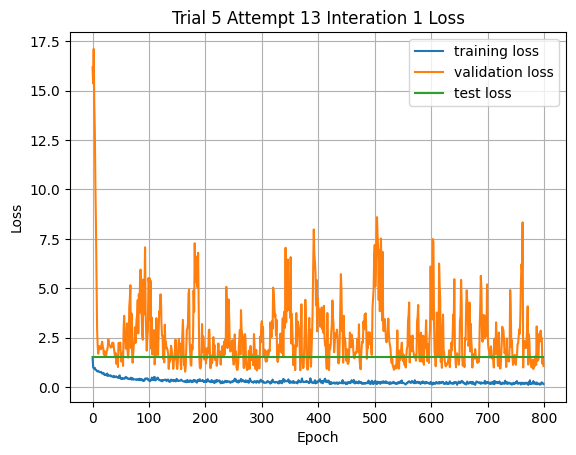

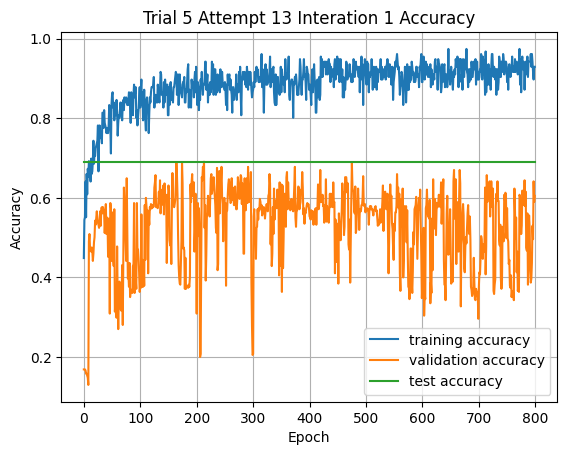

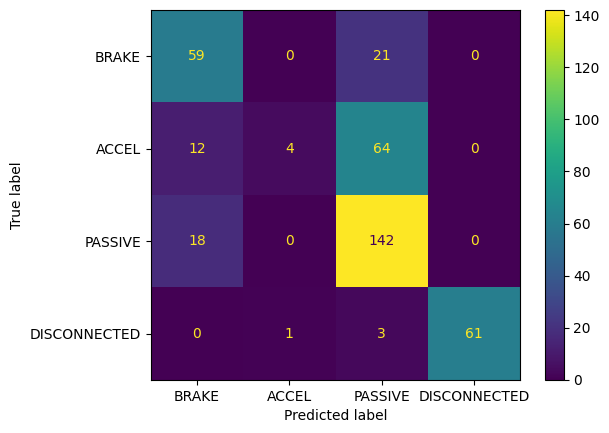

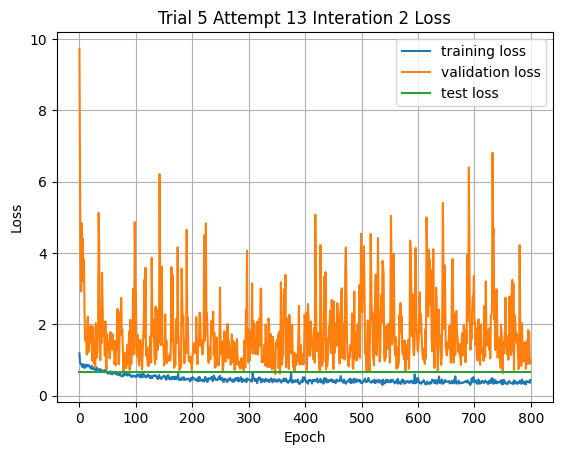

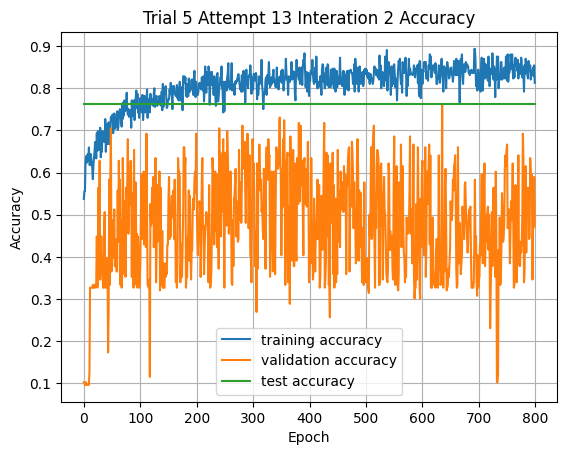

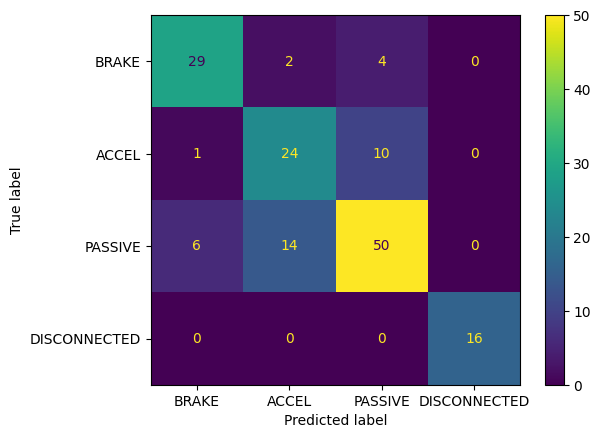

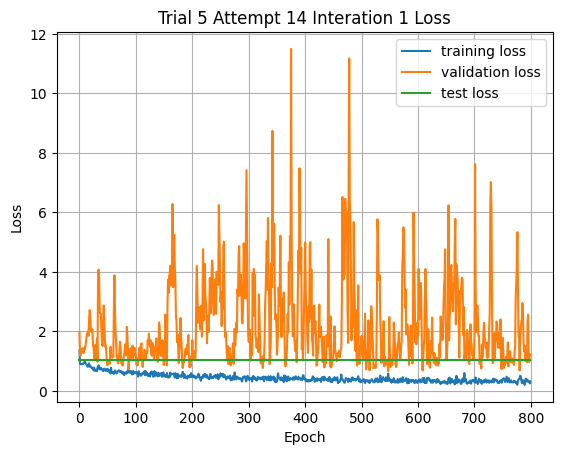

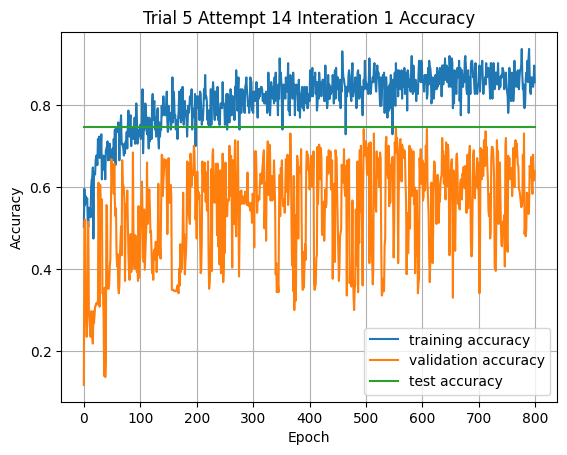

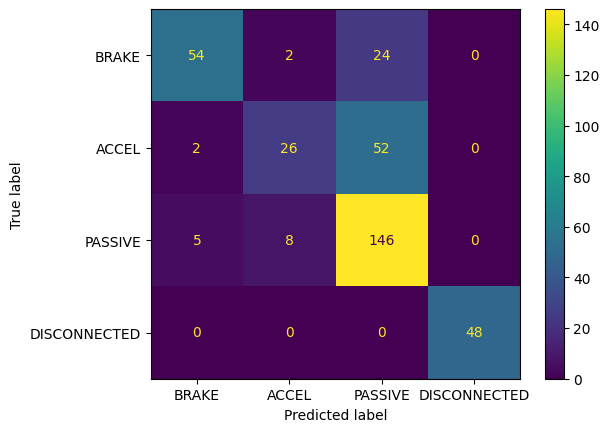

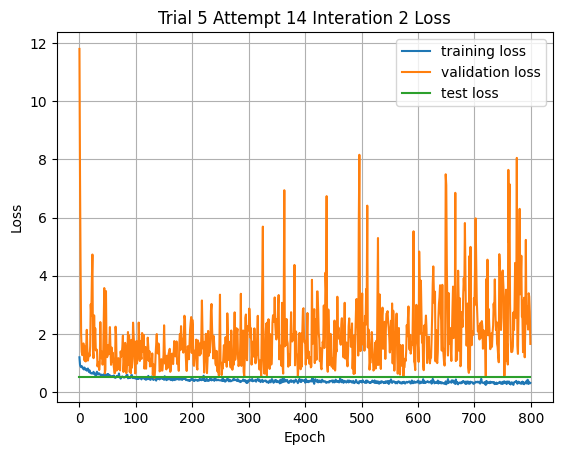

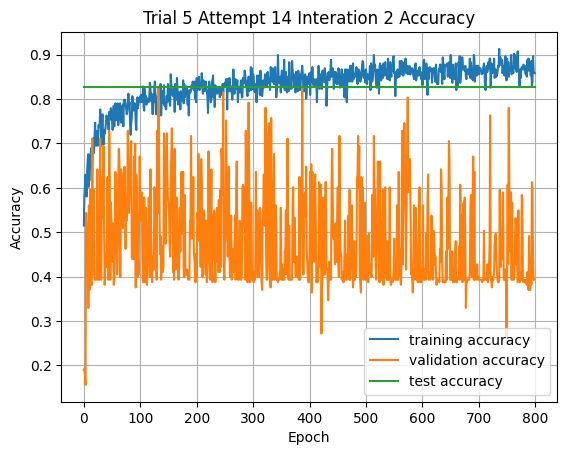

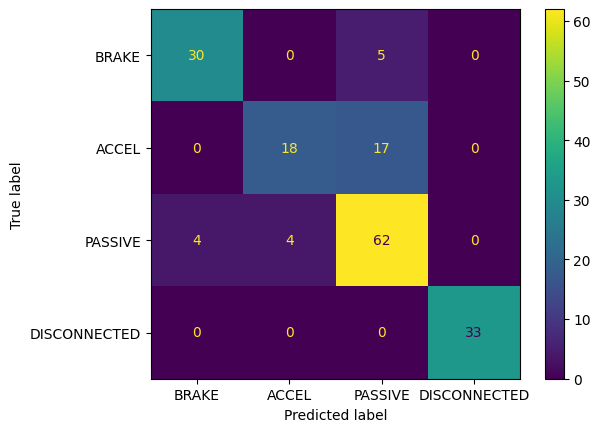

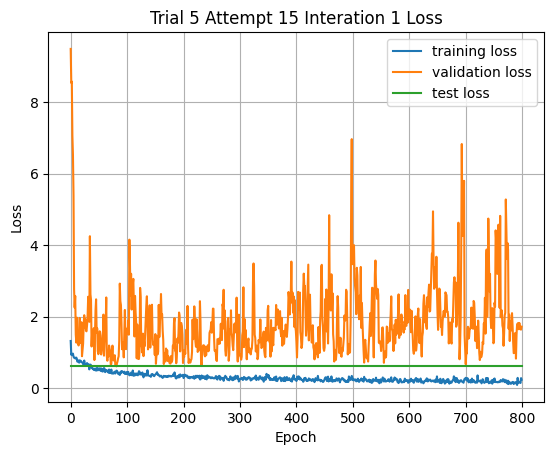

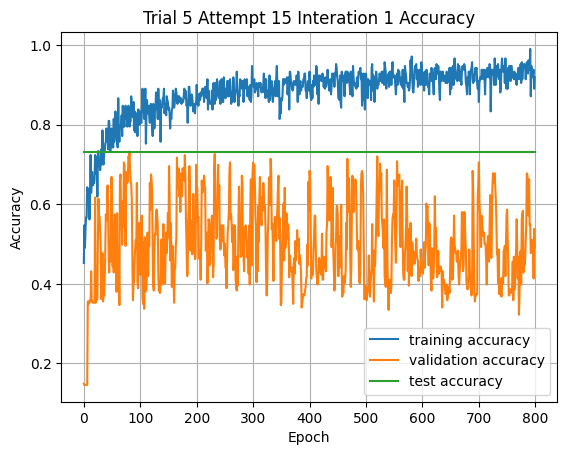

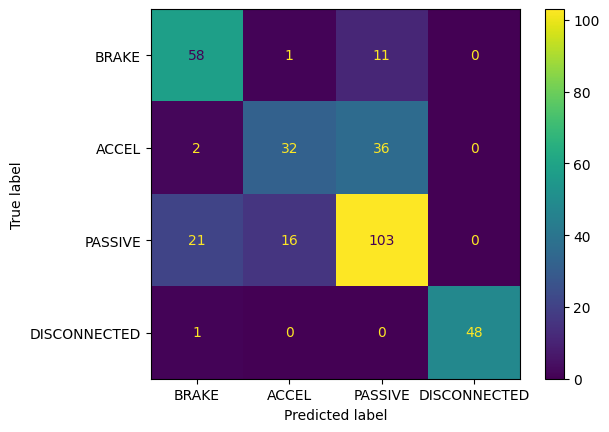

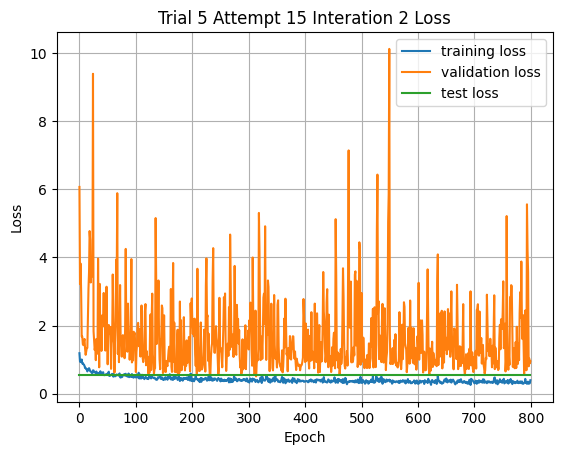

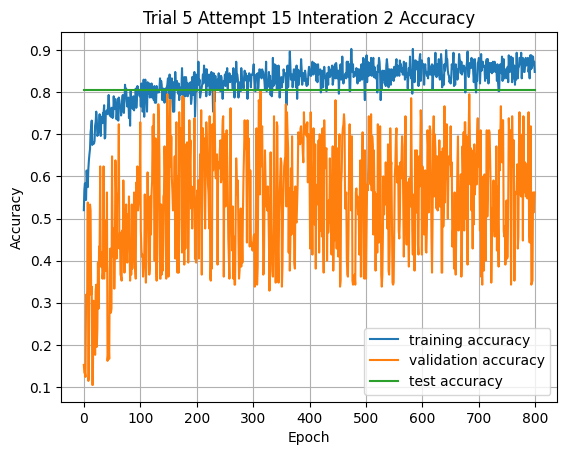

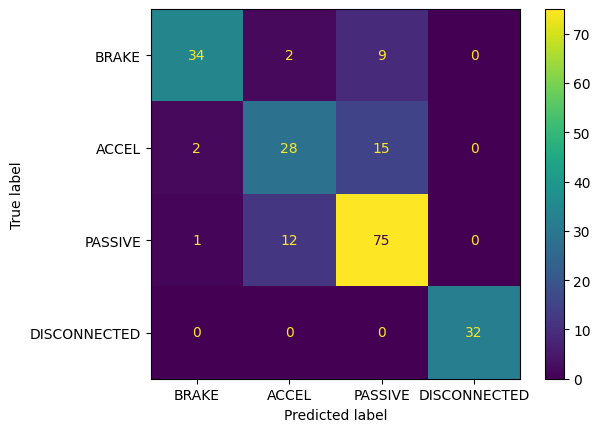

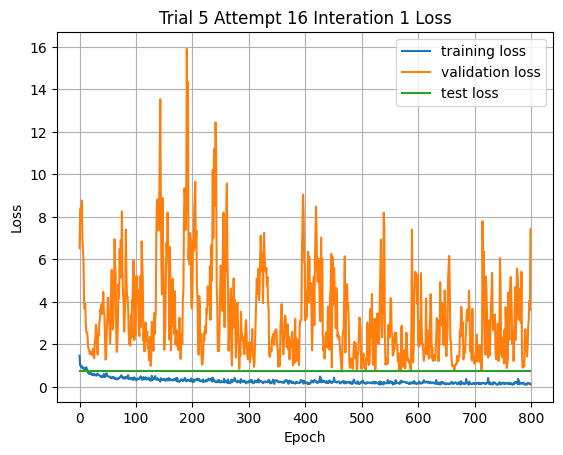

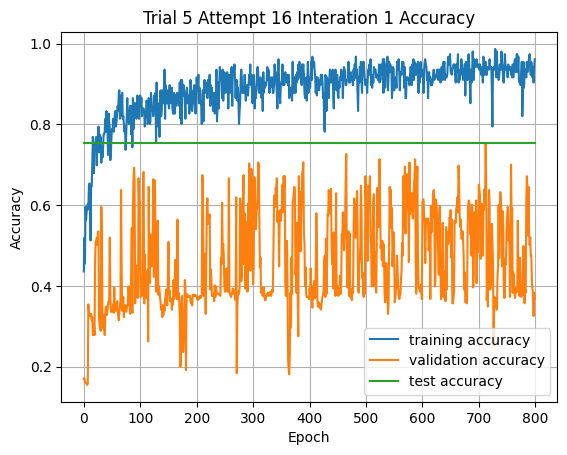

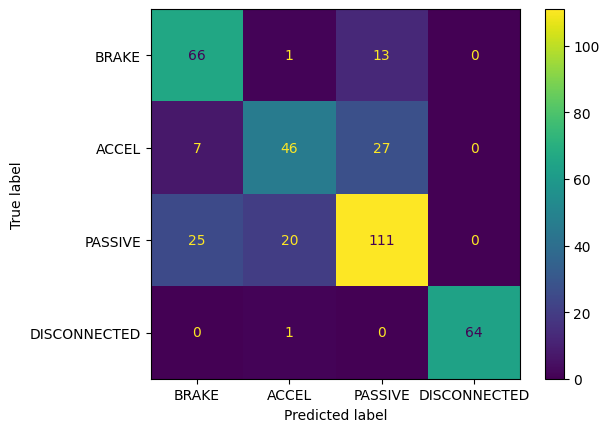

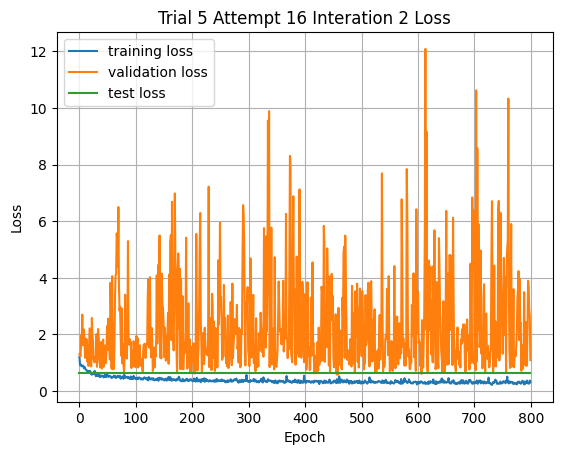

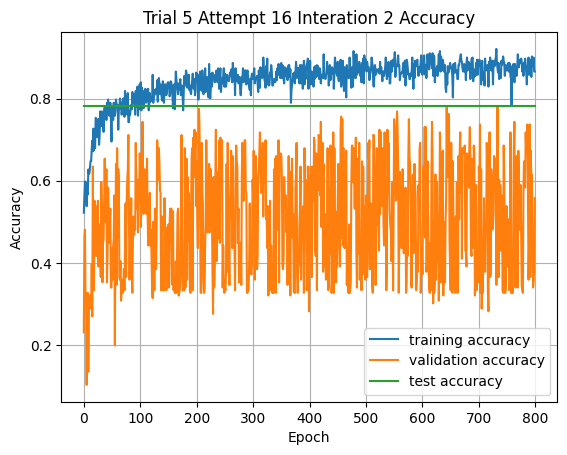

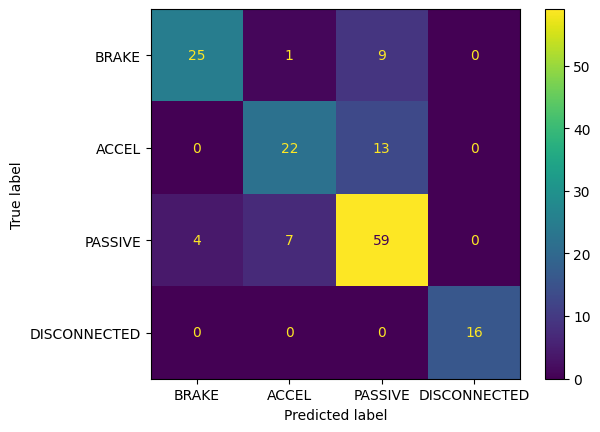

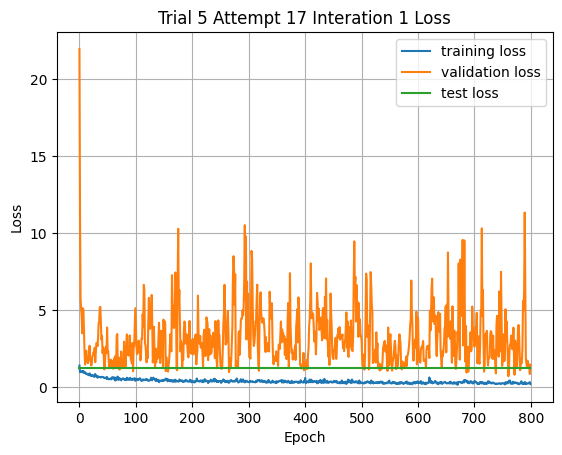

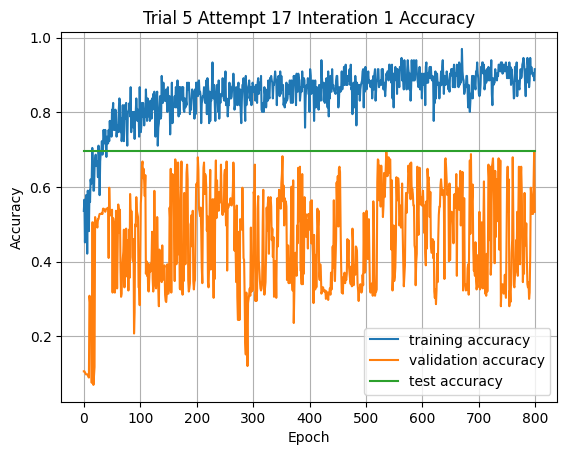

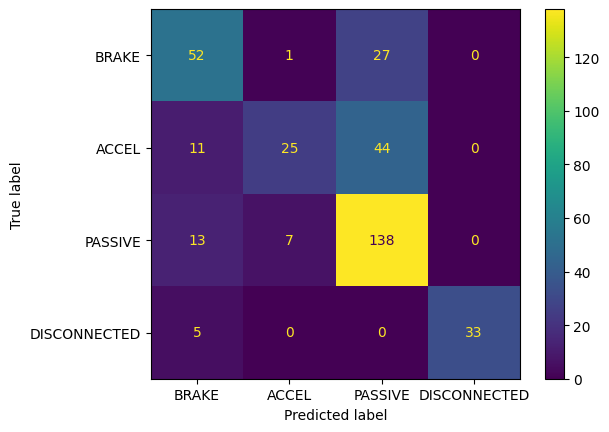

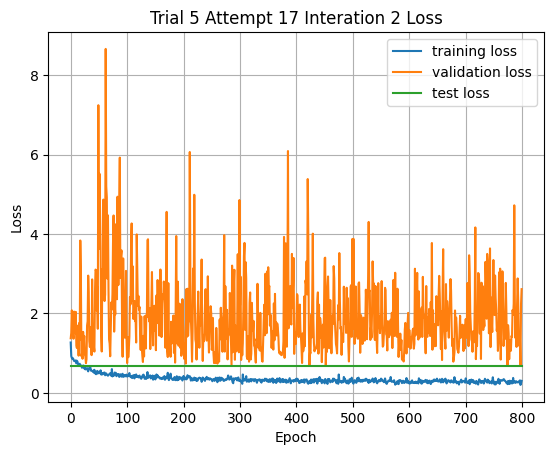

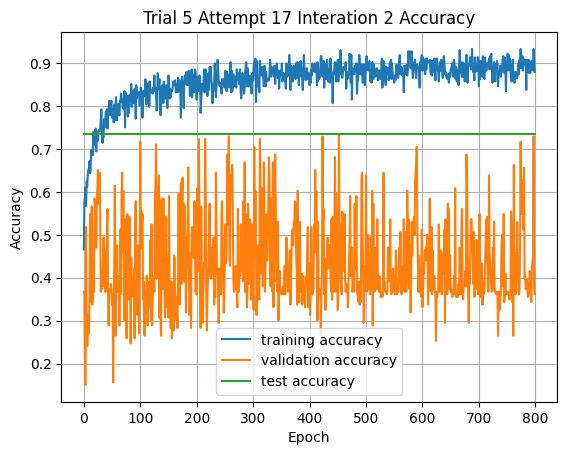

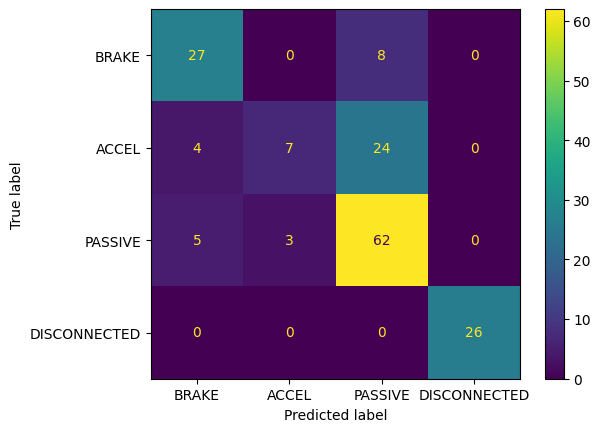

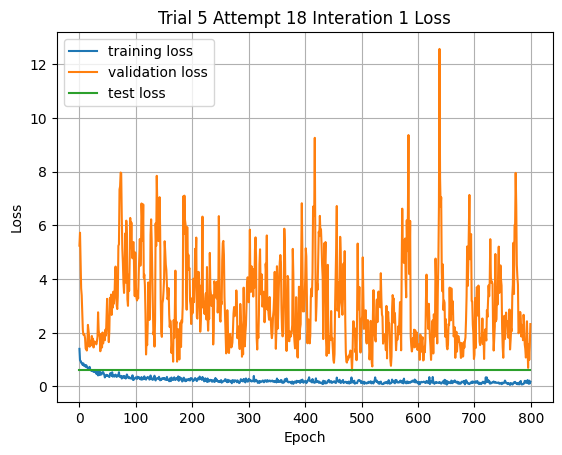

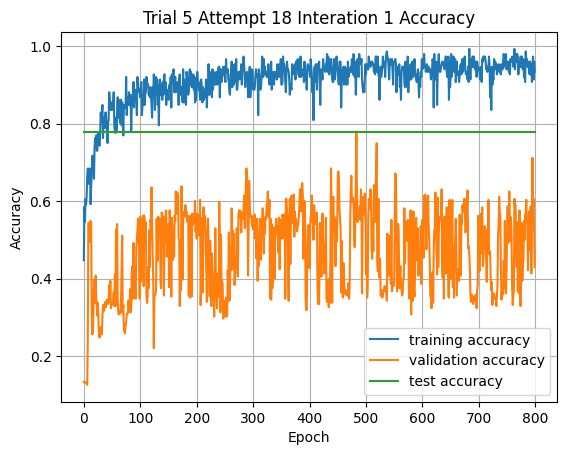

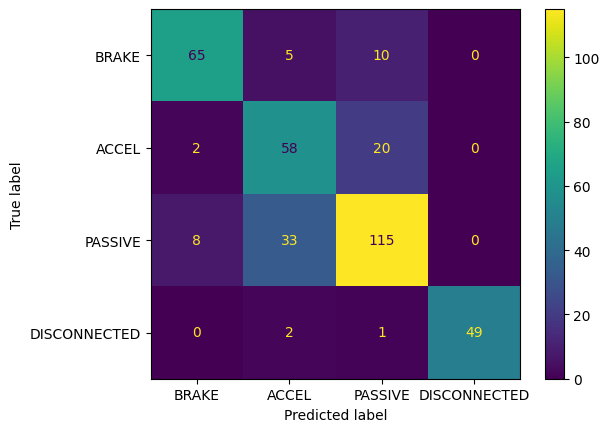

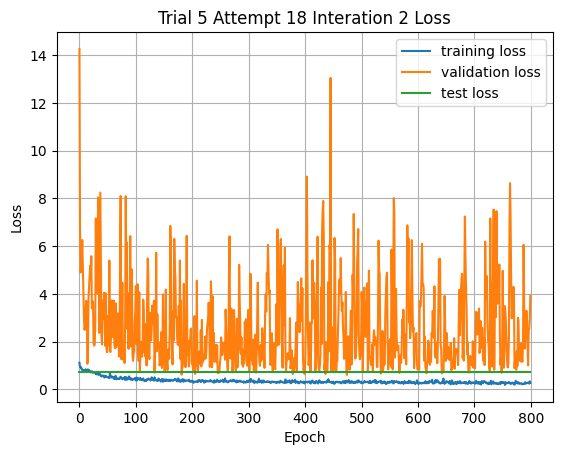

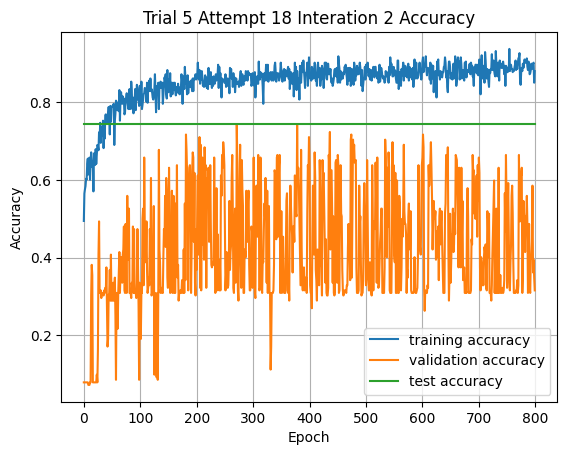

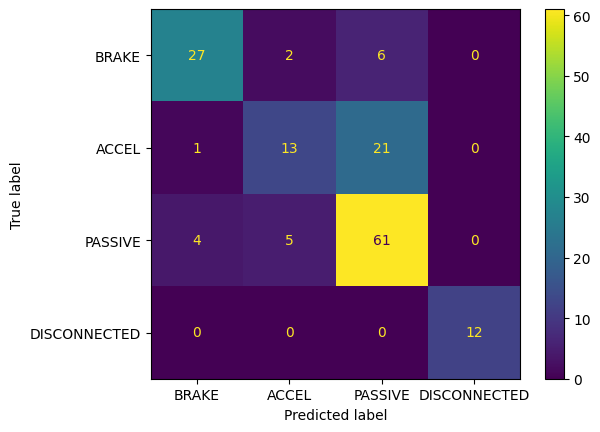

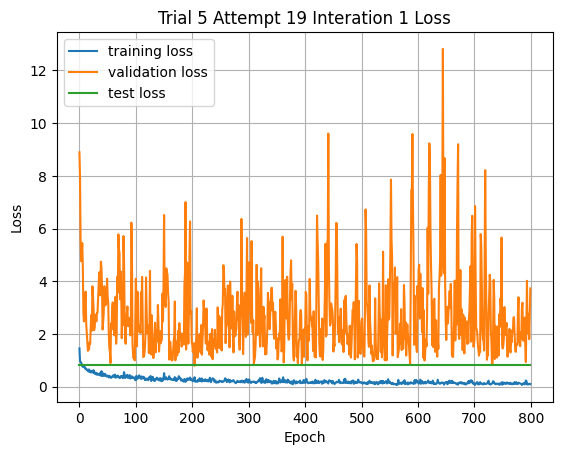

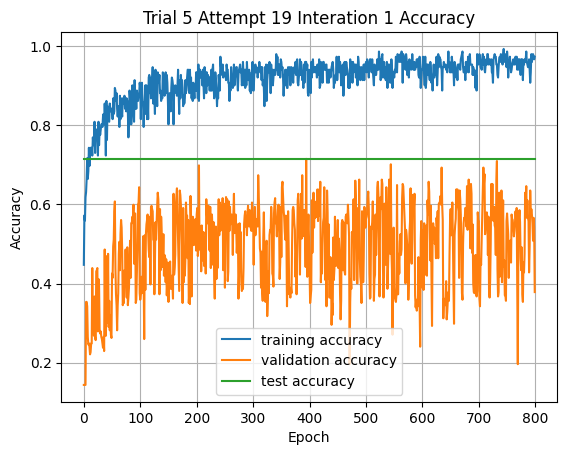

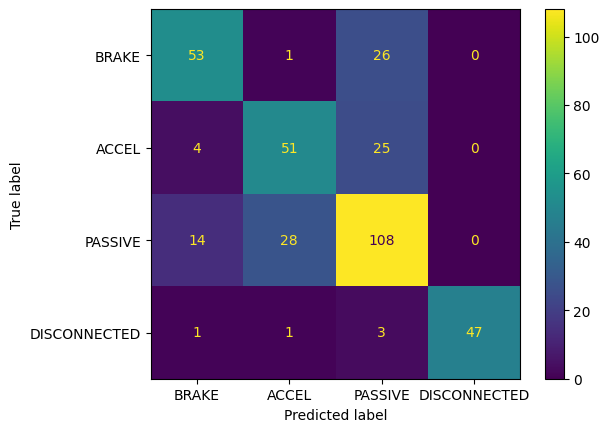

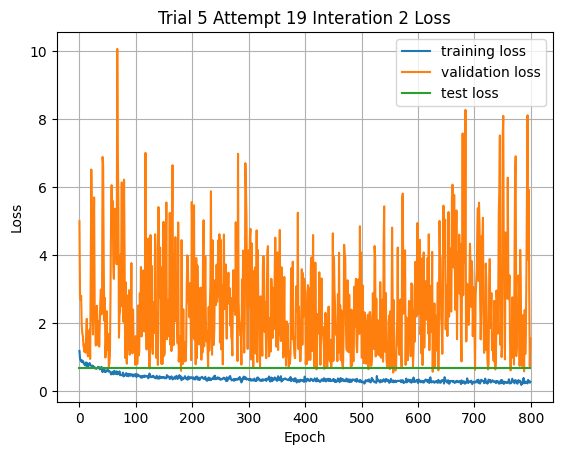

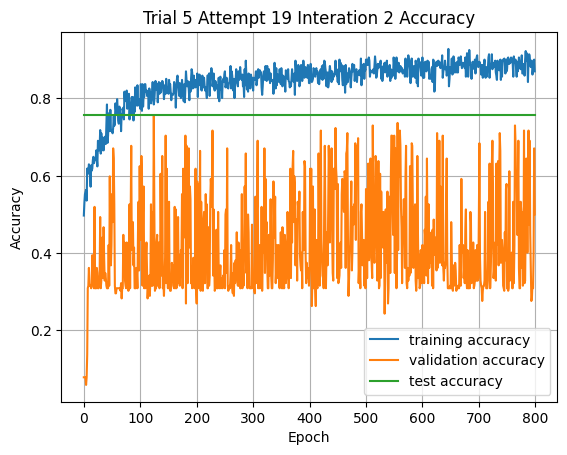

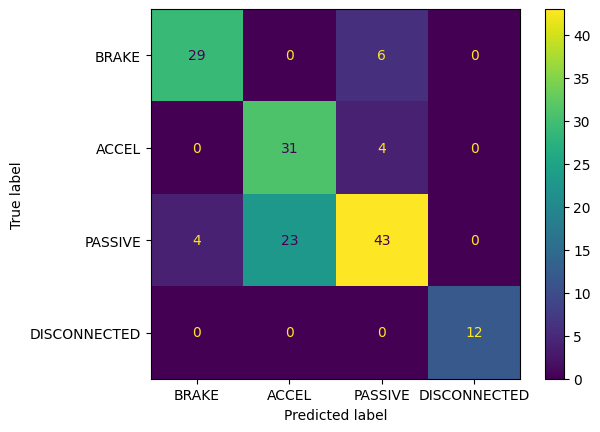

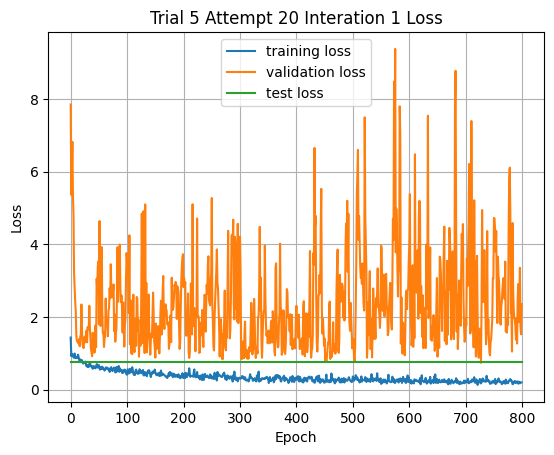

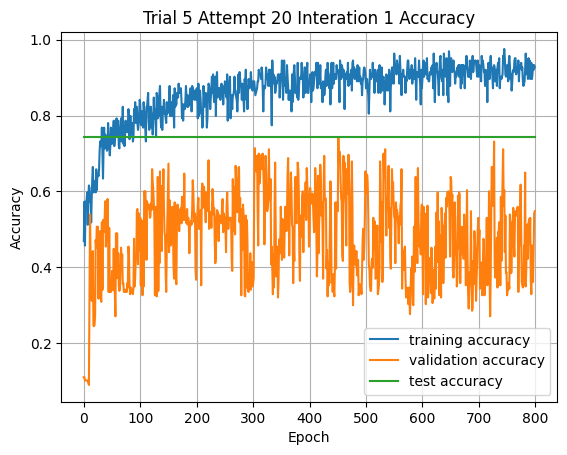

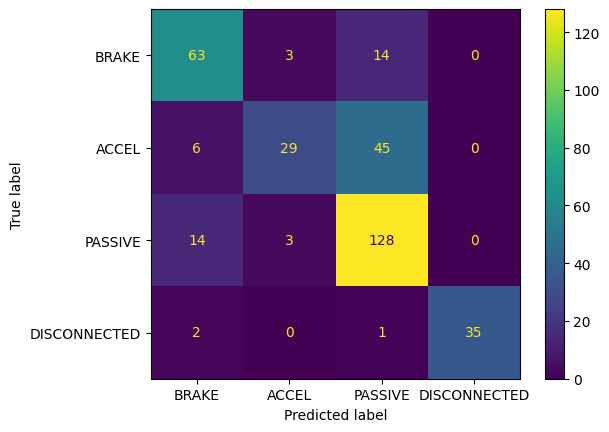

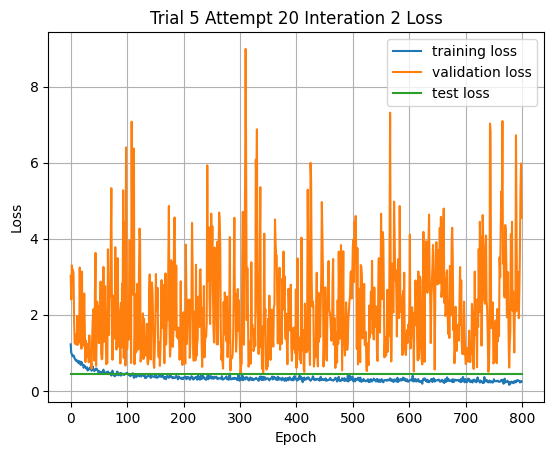

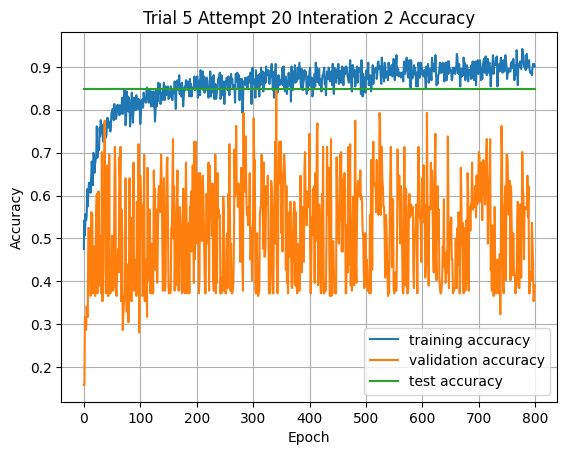

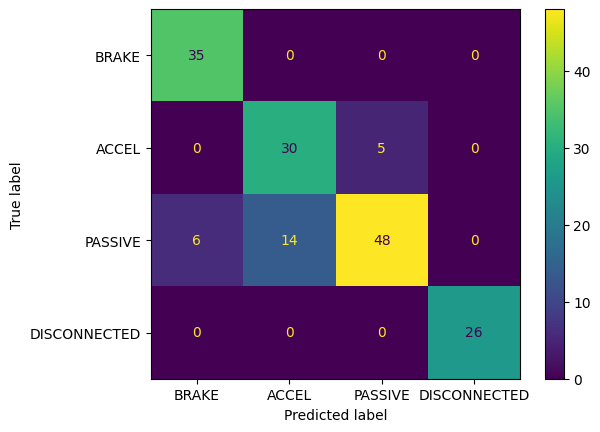

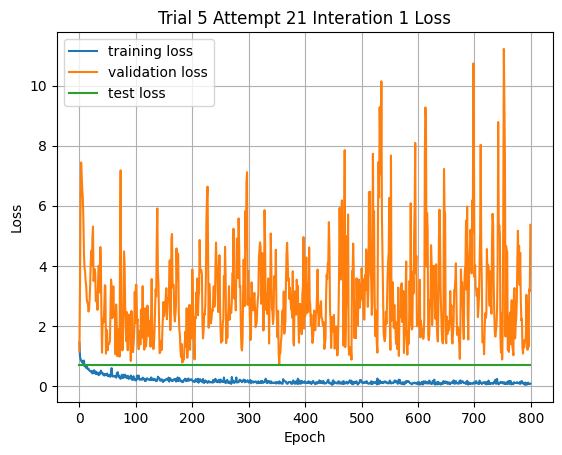

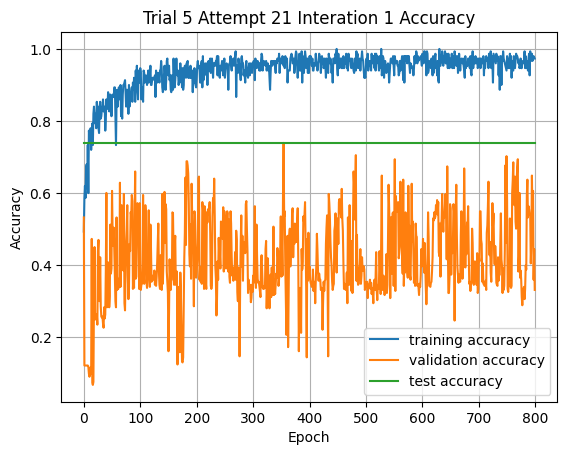

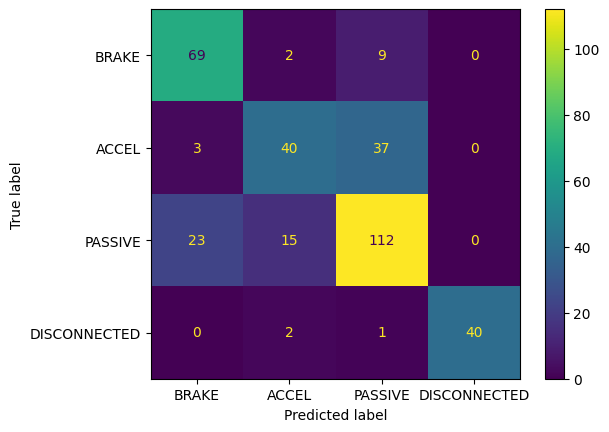

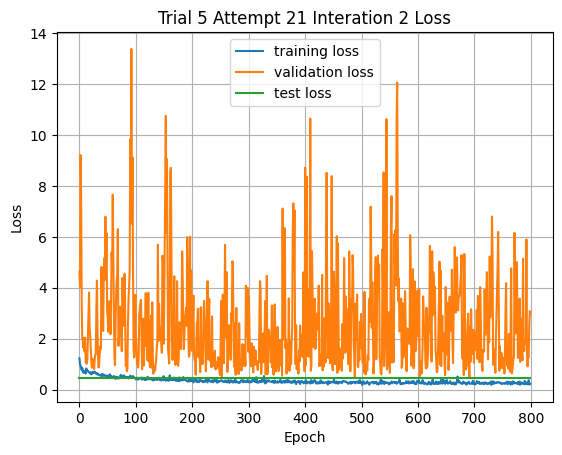

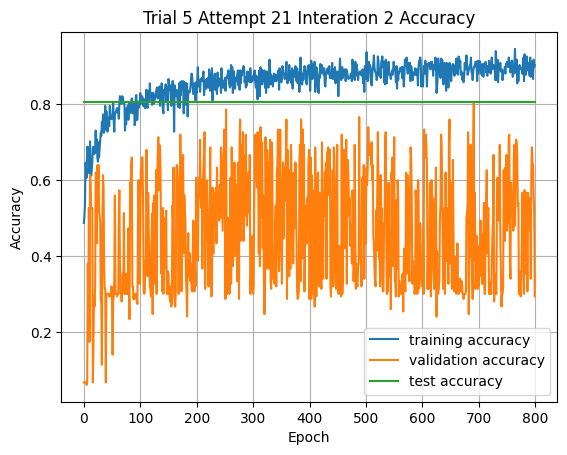

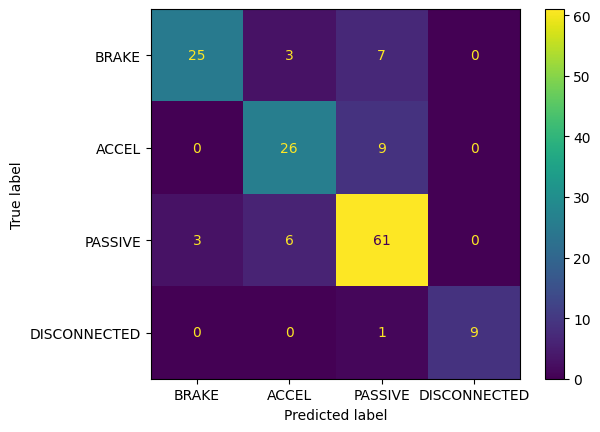

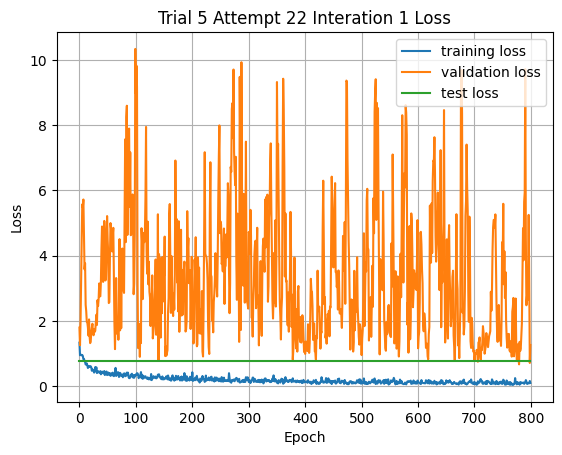

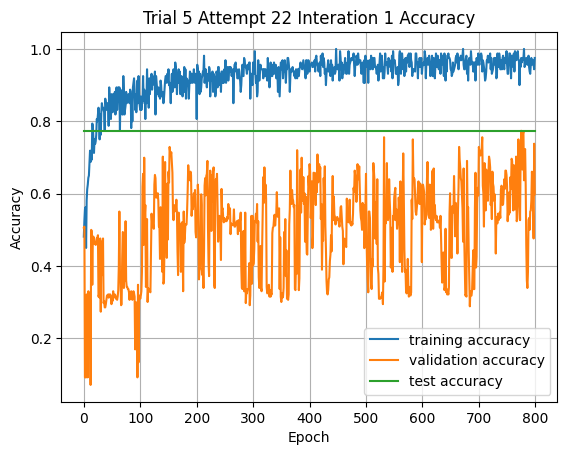

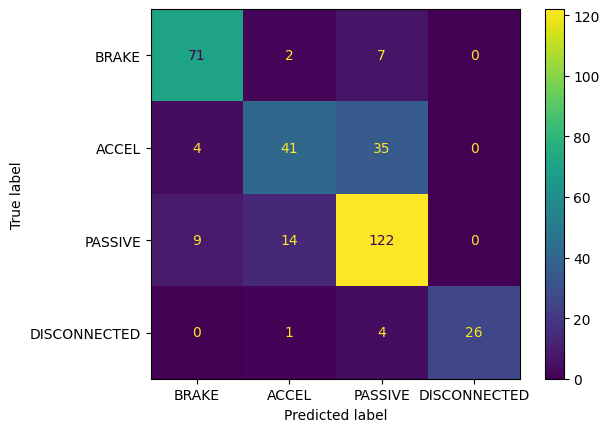

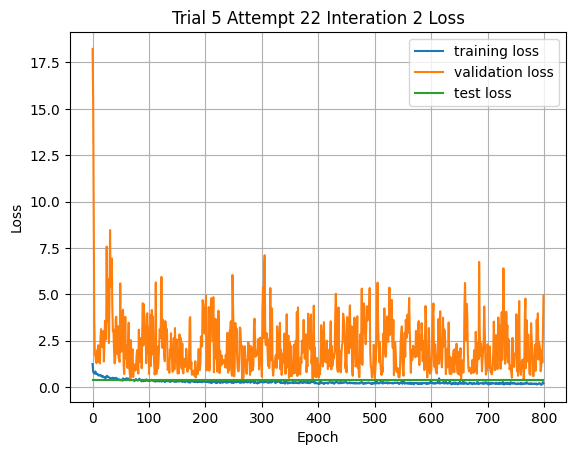

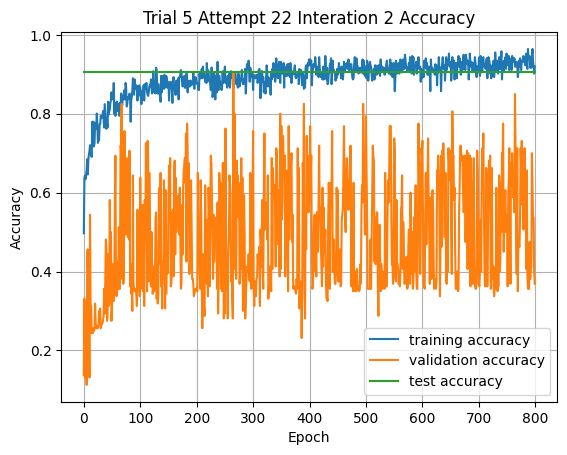

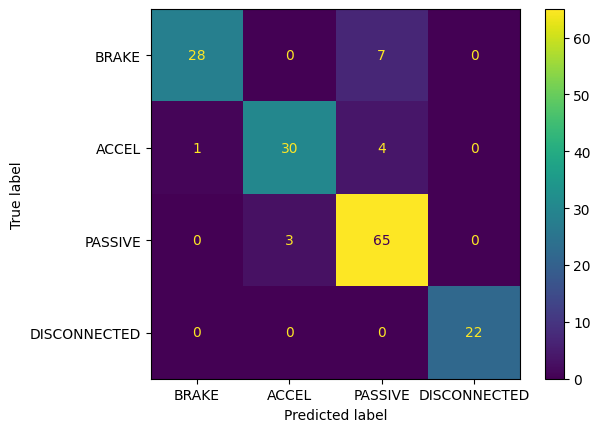

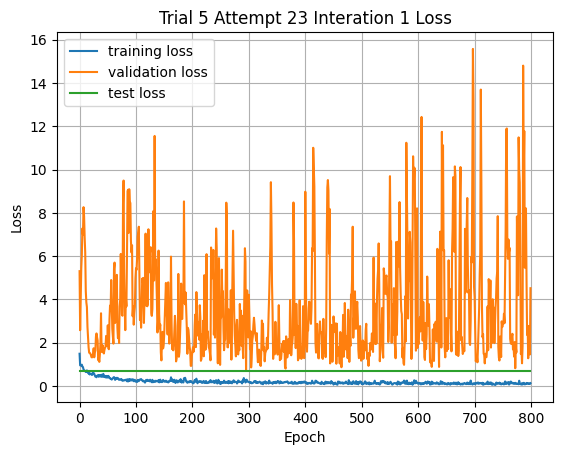

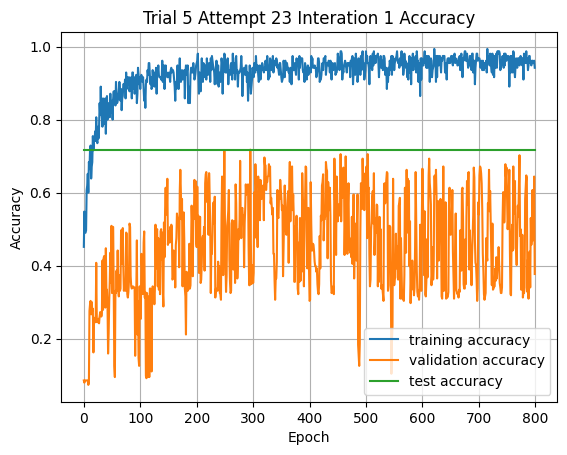

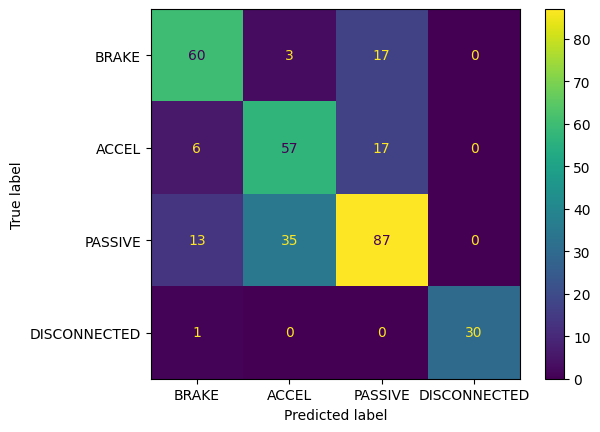

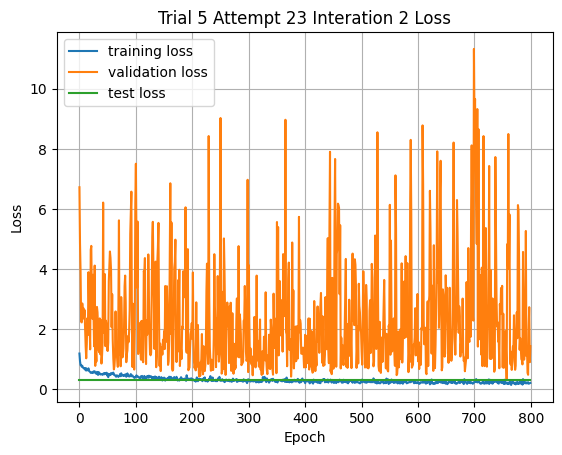

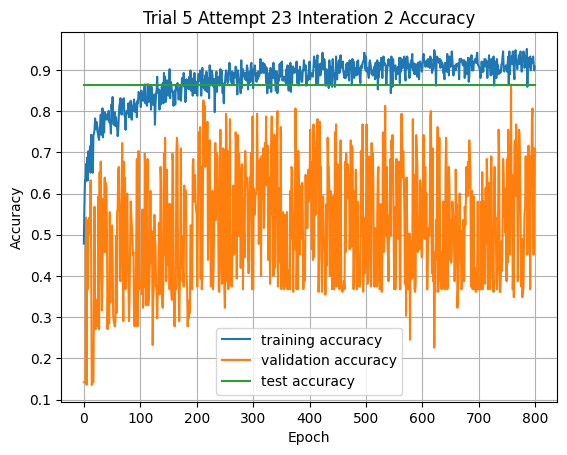

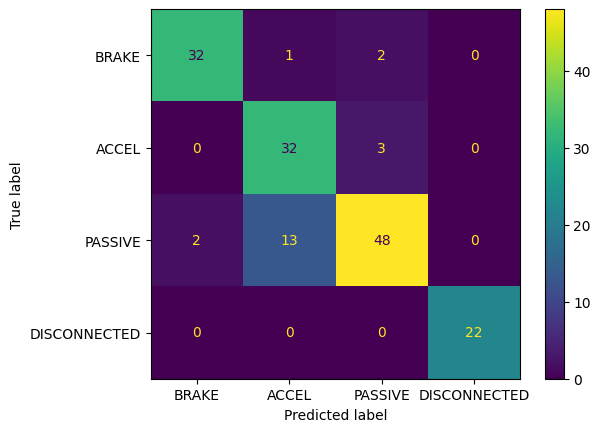

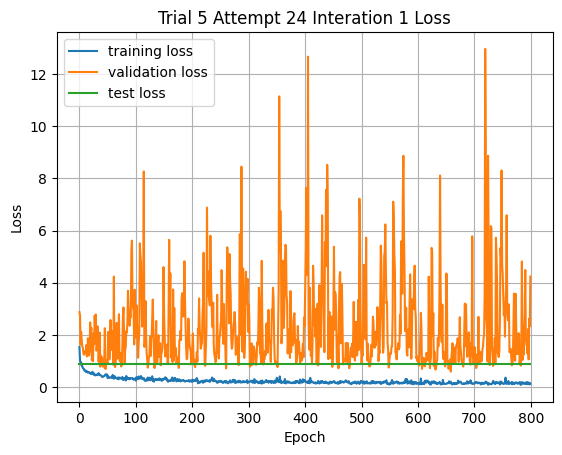

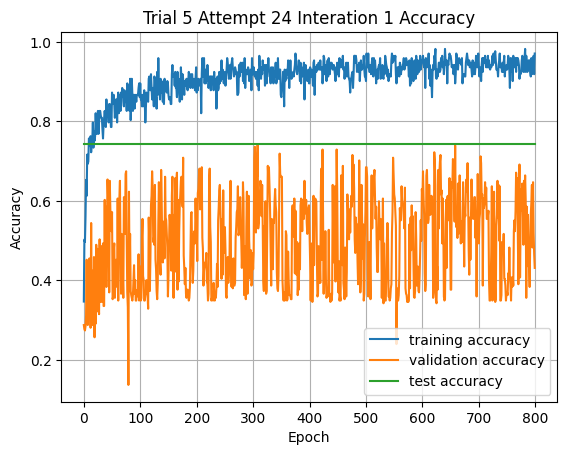

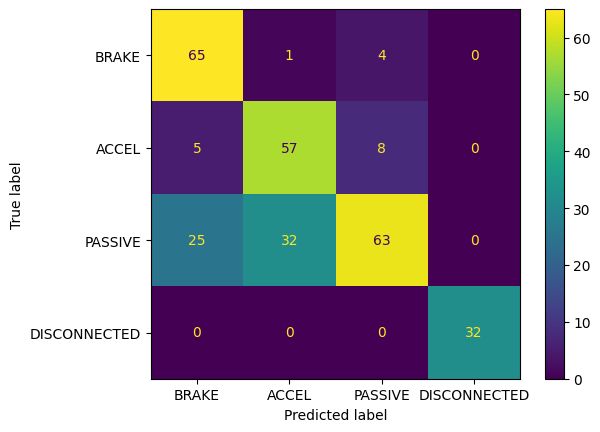

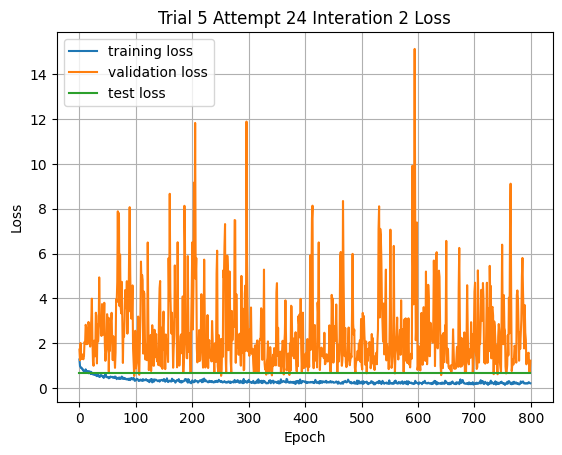

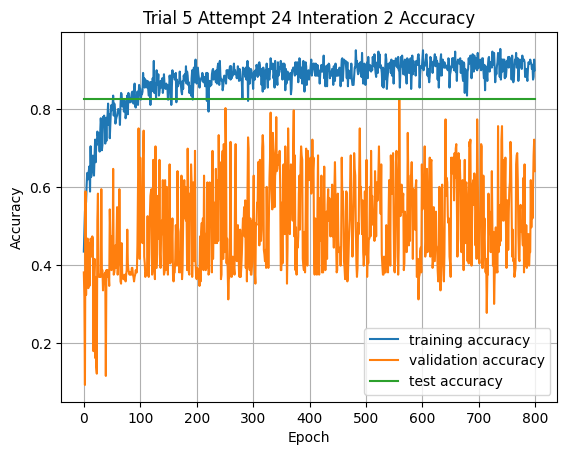

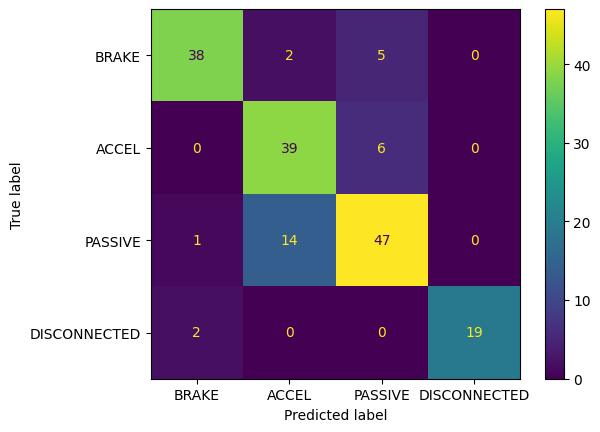

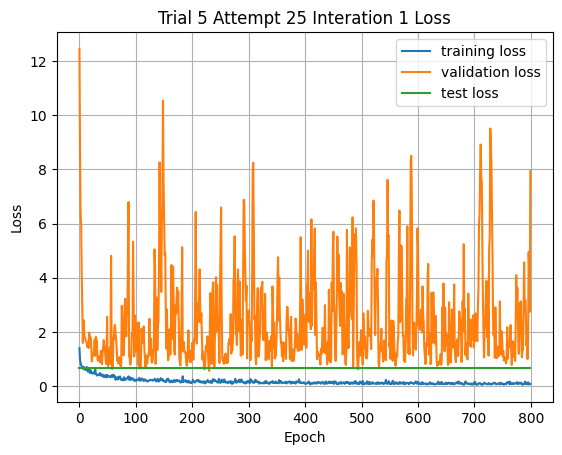

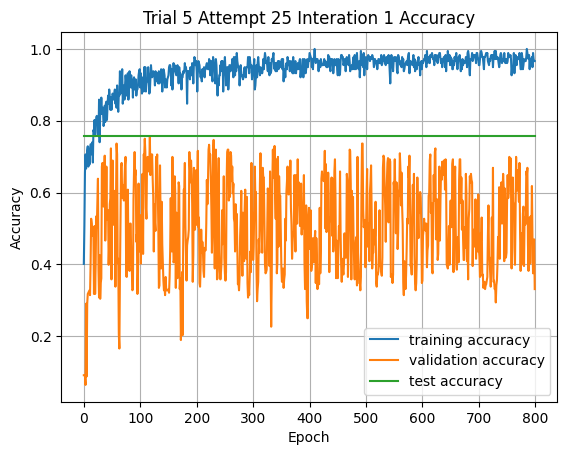

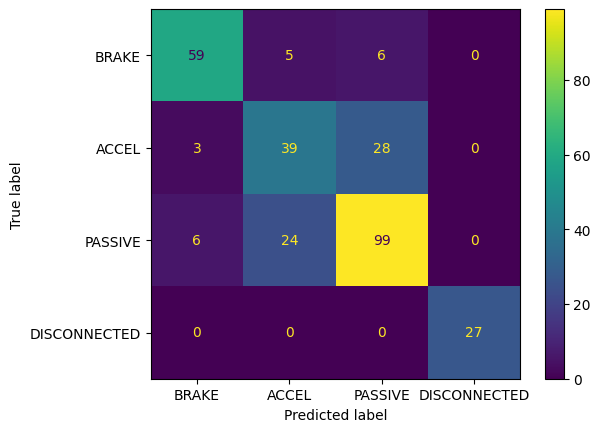

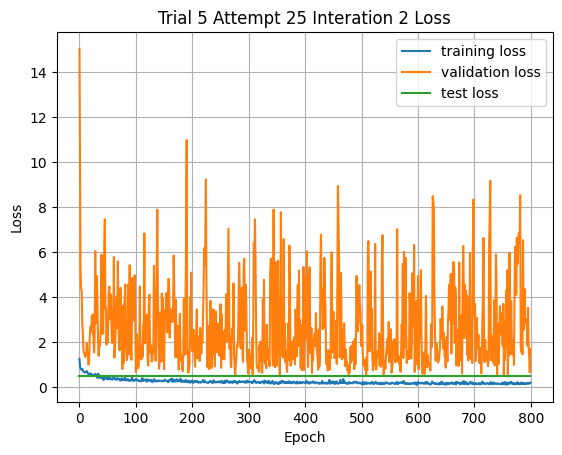

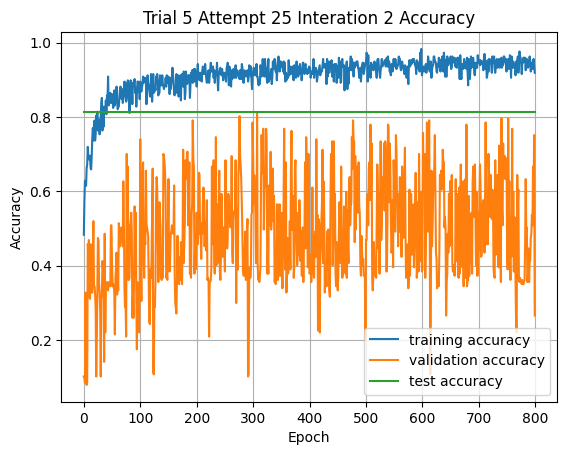

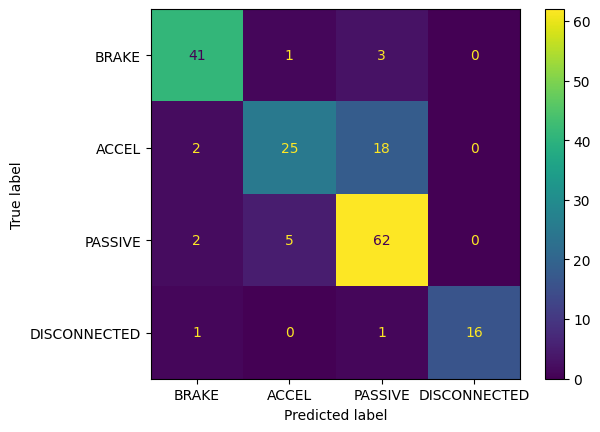

In [ ]:
window_times = [400, 500, 600, 700]
wait_times = [100]
hold_times = [50, 100, 150, 200]

results = defaultdict(list)
attempt_num = 13

for window_time, wait_time, hold_time in product(window_times, wait_times, hold_times):
    max_iter = 2
    attempt_results = attempt(attempt_num=attempt_num,
                      xv_n_splits=2, max_iter=max_iter,
                      hold_time=hold_time, wait_time=wait_time, window_time=window_time,
                      freq_filter_num=[2,4,8,16], spatial_filter_num=[1,1,1,1], drop_rate=0.2,
                      learning_rate=0.01, beta_1=0.9, beta_2=0.999,
                      epochs=800, batch_size=32
                      )

    results['attempt'].append(attempt_num)
    results['window'].append(window_time)
    results['wait'].append(wait_time)
    results['hold'].append(hold_time)
    results['train_acc'].append(sum(attempt_results['train_acc'])/max_iter)
    results['train_loss'].append(sum(attempt_results['train_loss'])/max_iter)
    results['val_acc'].append(sum(attempt_results['val_acc'])/max_iter)
    results['val_loss'].append(sum(attempt_results['val_loss'])/max_iter)
    results['test_acc'].append(sum(attempt_results['test_acc'])/max_iter)
    results['test_loss'].append(sum(attempt_results['test_loss'])/max_iter)
    
    attempt_num += 1



In [63]:
new_results = results

In [59]:
old_results = results

In [64]:
results = dict()

for key in old_results.keys():
    results[key] = old_results[key] + new_results[key]

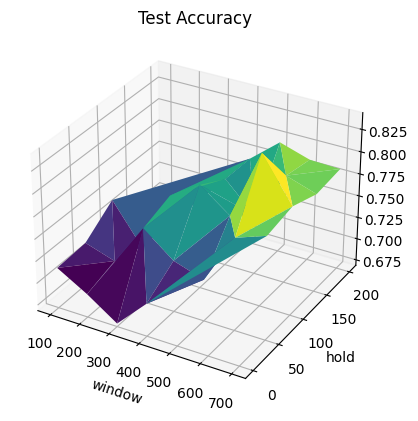

In [65]:
test_acc_fig = os.path.join(RESULTS_DIR, 'experiment%s_test_acc.png' % EXPER_NUM)
ax = plt.axes(projection ='3d')
ax.plot_trisurf(results['window'], results['hold'], results['test_acc'], cmap ='viridis')
plt.xlabel('window')
plt.ylabel('hold')
plt.title('Test Accuracy')

plt.savefig(test_acc_fig)

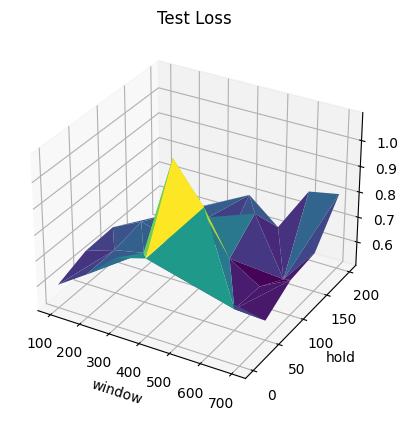

In [66]:
test_loss_fig = os.path.join(RESULTS_DIR, 'experiment%s_test_loss.png' % EXPER_NUM)
ax = plt.axes(projection ='3d')
ax.plot_trisurf(results['window'], results['hold'], results['test_loss'], cmap ='viridis')
plt.xlabel('window')
plt.ylabel('hold')
plt.title('Test Loss')

plt.savefig(test_loss_fig)

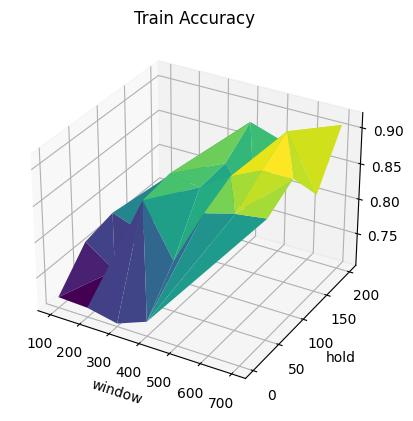

In [67]:
train_acc_fig = os.path.join(RESULTS_DIR, 'experiment%s_train_acc.png' % EXPER_NUM)
ax = plt.axes(projection ='3d')
ax.plot_trisurf(results['window'], results['hold'], results['train_acc'], cmap ='viridis')
plt.xlabel('window')
plt.ylabel('hold')
plt.title('Train Accuracy')

plt.savefig(train_acc_fig)

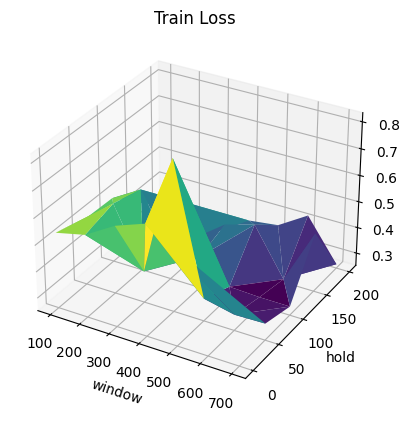

In [68]:
train_loss_fig = os.path.join(RESULTS_DIR, 'experiment%s_train_loss.png' % EXPER_NUM)
ax = plt.axes(projection ='3d')
ax.plot_trisurf(results['window'], results['hold'], results['train_loss'], cmap ='viridis')
plt.xlabel('window')
plt.ylabel('hold')
plt.title('Train Loss')

plt.savefig(train_loss_fig)

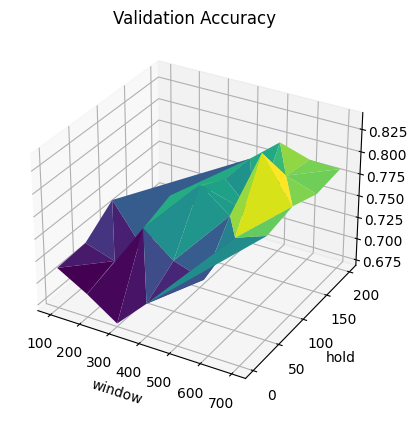

In [69]:
val_acc_fig = os.path.join(RESULTS_DIR, 'experiment%s_val_acc.png' % EXPER_NUM)
ax = plt.axes(projection ='3d')
ax.plot_trisurf(results['window'], results['hold'], results['val_acc'], cmap ='viridis')
plt.xlabel('window')
plt.ylabel('hold')
plt.title('Validation Accuracy')

plt.savefig(val_acc_fig)

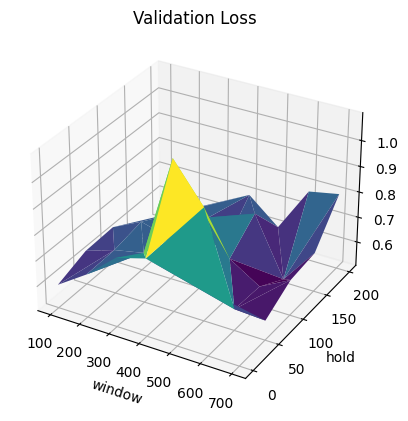

In [70]:
val_loss_fig = os.path.join(RESULTS_DIR, 'experiment%s_val_loss.png' % EXPER_NUM)
ax = plt.axes(projection ='3d')
ax.plot_trisurf(results['window'], results['hold'], results['val_loss'], cmap ='viridis')
plt.xlabel('window')
plt.ylabel('hold')
plt.title('Validation Loss')

plt.savefig(val_loss_fig)